# Stock Market Prediction using Numerical and Textual Analysis

## Objective:
Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices and sentimental analysis of news headlines.
### Done By :SHUBHAM KUMAR SINGH

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import altair as alt  
import statsmodels.api as sm 
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

In [2]:
import yfinance as yf
bse_data = yf.download('^BSESN', start='2015-01-01', end='2020-12-31')
#since our Textual Analysis dataset containing news from Times of India News Headlines is only till 31st December 2020. 
#So we will assume today is 30th December 2020 and tomorrow is 31st December 2020. And we have to predict the stock price 
#((high+low+close)/3) and closing price of BSE index 
#for tomorrow 31st December 2020.
hiddenbse_data = yf.download('^BSESN', start='2020-12-31', end='2021-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
bse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
hiddenbse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
bse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1473 entries, 2015-01-02 to 2020-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1473 non-null   float64
 1   High       1473 non-null   float64
 2   Low        1473 non-null   float64
 3   Close      1473 non-null   float64
 4   Adj Close  1473 non-null   float64
 5   Volume     1473 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 80.6 KB


In [6]:
hiddenbse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2020-12-31 to 2020-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1 non-null      float64
 1   High       1 non-null      float64
 2   Low        1 non-null      float64
 3   Close      1 non-null      float64
 4   Adj Close  1 non-null      float64
 5   Volume     1 non-null      int64  
dtypes: float64(5), int64(1)
memory usage: 56.0 bytes


In [7]:
bse_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [8]:
bse_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,46072.300781,46513.320312,45899.101562,46444.179688,46444.179688,10500
2020-12-24,46743.488281,47053.398438,46539.019531,46973.539062,46973.539062,13700
2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,47353.750000,9600
2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,47613.078125,12800
2020-12-30,47789.031250,47807.851562,47358.359375,47746.218750,47746.218750,15600


In [9]:
hiddenbse_data.head()
#We will predict the stock price for 31st December 2020.
#hiddenbse_data will be used to check whether our prediction is exact or close to the actual value.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,47753.109375,47896.96875,47602.121094,47751.328125,47751.328125,13900


In [10]:
bse_data.reset_index(inplace=True)

In [11]:
bse_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [12]:
hiddenbse_data.reset_index(inplace=True)

In [13]:
hiddenbse_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-31,47753.109375,47896.96875,47602.121094,47751.328125,47751.328125,13900


In [14]:
bse_data['Date'] = pd.to_datetime(bse_data['Date'], format = '%Y%m%d')
hiddenbse_data['Date'] = pd.to_datetime(hiddenbse_data['Date'], format = '%Y%m%d')

In [15]:
#Let's calculate the actual price of the stock on 31st December so that we can compare it with predicted value.
hiddenbsedata_price = round((hiddenbse_data['High'] + hiddenbse_data['Low'] + hiddenbse_data['Close'])/ 3, 2)
hiddenbsedata_price #actual price of stock on 31st December

0    47750.14
dtype: float64

# Rolling Window Analysis of Time Series
Rolling-window analysis of a time-series model assesses:

The stability of the model over time. A common time-series model assumption is that the coefficients are constant with respect to time. Checking for instability amounts to examining whether the coefficients are time-invariant.

The forecast accuracy of the model.

In [16]:
def stock_weekmovingavg(wks, df):
    Dateclose_data = pd.DataFrame({'Date': df['Date'], 'Close':df['Close']})
    Dateclose_data.set_index('Date', inplace=True)
    num = wks * 5   #calculating the number of days in the week. 5 days because BSE is open for 5 days / week
    Dateclose_data['Movingavg'] = Dateclose_data['Close'].rolling(window=num).mean().shift()
    return Dateclose_data.dropna()

## 4 Weeks Moving Average

In [17]:
stock_weekmovingavg(4, bse_data).head()

,Close,Movingavg
Date,,
2015-02-02,29122.269531,28256.509570
2015-02-03,29000.140625,28318.228027
2015-02-04,28883.109375,28376.119043
2015-02-05,28850.970703,28470.901465
2015-02-06,28717.910156,28568.008984


<AxesSubplot:xlabel='Date'>

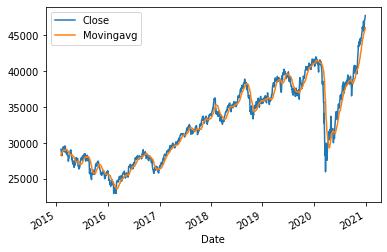

In [18]:
stock_weekmovingavg(4, bse_data).plot()

In [19]:
altdata_fourweek = stock_weekmovingavg(4, bse_data)
altdata_fourweek.reset_index(inplace=True)
altdata_fourweek.rename(columns={list(altdata_fourweek)[0]:'Date'}, inplace=True)

In [20]:
alt.Chart(altdata_fourweek).mark_point().encode(
    x='Date',
    y='Movingavg'
)

alt.Chart(...)

In [21]:
altdata_fourweek['Date']

0      2015-02-02
1      2015-02-03
2      2015-02-04
3      2015-02-05
4      2015-02-06
          ...    
1448   2020-12-23
1449   2020-12-24
1450   2020-12-28
1451   2020-12-29
1452   2020-12-30
Name: Date, Length: 1453, dtype: datetime64[ns]

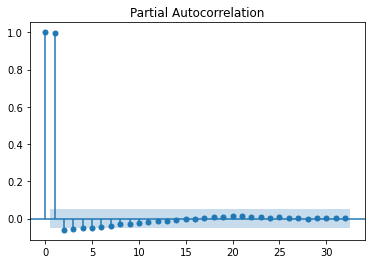

In [22]:
plotfourweek = altdata_fourweek.filter(['Date', 'Movingavg'], axis=1) 
plotfourweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fourweek['Date']))) 
del plotfourweek['Date']
sm.graphics.tsa.plot_pacf(plotfourweek.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0 and 1. Since it is more than 0 and almost equal to 1 so 0 and 1 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions (which is not vividly seen in the above plot)

## 16 Weeks Moving Average

In [23]:
stock_weekmovingavg(16, bse_data).head()

,Close,Movingavg
Date,,
2015-05-05,27440.140625,28447.880933
2015-05-06,26717.369141,28442.283936
2015-05-07,26599.109375,28428.222046
2015-05-08,27105.390625,28423.367651
2015-05-11,27507.300781,28425.824780


<AxesSubplot:xlabel='Date'>

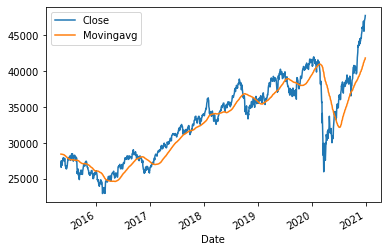

In [24]:
stock_weekmovingavg(16, bse_data).plot()

In [25]:
altdata_sixteenweek = stock_weekmovingavg(16, bse_data)
altdata_sixteenweek.reset_index(inplace=True)
altdata_sixteenweek.rename(columns={list(altdata_sixteenweek)[0]:'Date'}, inplace=True)


In [26]:
alt.Chart(altdata_sixteenweek).mark_point().encode(
    x='Date',
    y='Movingavg'
)

alt.Chart(...)

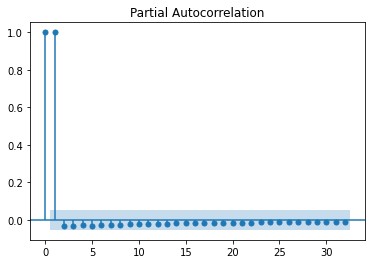

In [27]:
plotsixteenweek = altdata_sixteenweek.filter(['Date', 'Movingavg'], axis=1) 
plotsixteenweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_sixteenweek['Date']))) 
del plotsixteenweek['Date']
sm.graphics.tsa.plot_pacf(plotsixteenweek.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0 and 1. Since it is more than 0 and almost equal to 1 so 0 and 1 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions (which is not vividly seen in the above plot)

## 52 Weeks Moving Average

In [28]:
stock_weekmovingavg(52, bse_data).head()

,Close,Movingavg
Date,,
2016-01-25,24485.949219,27198.907963
2016-01-27,24492.390625,27185.823535
2016-01-28,24469.570312,27172.939190
2016-01-29,24870.689453,27163.254995
2016-02-01,24824.830078,27155.416031


<AxesSubplot:xlabel='Date'>

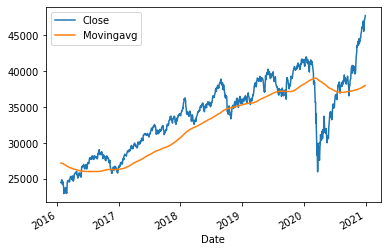

In [29]:
stock_weekmovingavg(52, bse_data).plot()

In [30]:
altdata_fiftytwoweek = stock_weekmovingavg(52, bse_data)
altdata_fiftytwoweek.reset_index(inplace=True)
altdata_fiftytwoweek.rename(columns={list(altdata_fiftytwoweek)[0]:'Date'}, inplace=True)


In [31]:
alt.Chart(altdata_fiftytwoweek).mark_point().encode(
    x='Date',
    y='Movingavg'
)

alt.Chart(...)

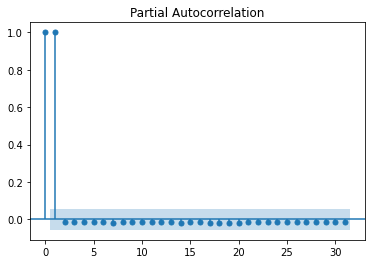

In [32]:
plotfiftytwoweek = altdata_fiftytwoweek.filter(['Date', 'Movingavg'], axis=1)
plotfiftytwoweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fiftytwoweek['Date']))) 
del plotfiftytwoweek['Date']
sm.graphics.tsa.plot_pacf(plotfiftytwoweek.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0 and 1. Since it is more than 0 and almost equal to 1 so 0 and 1 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions (which is not vividly seen in the above plot)

# Creating a rolling window of Size 20 and 10
Choose a rolling window size, m, i.e., the number of consecutive observation per rolling window. The size of the rolling window depends on the sample size, T, and periodicity of the data. In general, you can use a short rolling window size for data collected in short intervals, and a larger size for data collected in longer intervals. Longer rolling window sizes tend to yield smoother rolling window estimates than shorter sizes.

In [33]:
def rollingwindows(days, df):
    data = df.filter(['Date','Open','High','Low','Close'], axis=1) 
    data.set_index('Date', inplace=True)
    rollingwindows_data = data.rolling(window=days).mean().shift()
    return rollingwindows_data.dropna()

In [34]:
rollingwindows(20, bse_data).head()

,Open,High,Low,Close
Date,,,,
2015-02-02,28255.806836,28416.561035,28063.327539,28256.509570
2015-02-03,28336.924414,28483.094043,28135.290527,28318.228027
2015-02-04,28398.872949,28542.522559,28190.968555,28376.119043
2015-02-05,28470.653906,28614.257031,28285.349512,28470.901465
2015-02-06,28567.101465,28725.568555,28384.208008,28568.008984


<AxesSubplot:xlabel='Date'>

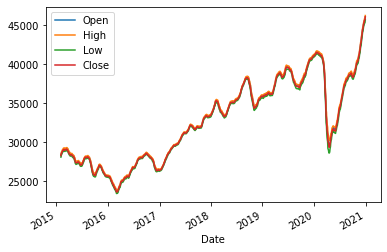

In [35]:
rollingwindows(20, bse_data).plot()

In [36]:
altdata_twentydays = rollingwindows(20, bse_data)
altdata_twentydays.reset_index(inplace=True)
altdata_twentydays.rename(columns={list(altdata_twentydays)[0]:'Date'}, inplace=True)

In [37]:
alt.Chart(altdata_twentydays).mark_point().encode(
    x ='Date',
    y = 'Close'
)

alt.Chart(...)

In [38]:
rollingwindows(10, bse_data).head()

,Open,High,Low,Close
Date,,,,
2015-01-16,27515.904883,27657.483008,27279.612891,27479.296484
2015-01-19,27569.437891,27681.345898,27322.217969,27502.695508
2015-01-20,27596.578906,27708.302930,27363.268945,27544.664453
2015-01-21,27659.640820,27821.338867,27502.047852,27724.385352
2015-01-22,27845.606836,28011.988867,27703.692969,27922.389258


<AxesSubplot:xlabel='Date'>

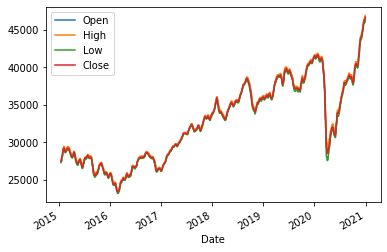

In [39]:
rollingwindows(10, bse_data).plot()

In [40]:
altdata_hundreddays = rollingwindows(10, bse_data)
altdata_hundreddays.reset_index(inplace=True)
altdata_hundreddays.rename(columns={list(altdata_hundreddays)[0]:'Date'}, inplace=True)

In [41]:
alt.Chart(altdata_hundreddays).mark_point().encode(
    x ='Date',
    y = 'Close'
)

alt.Chart(...)

# Creating the dummy time series:
Volume shocks : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether volume traded is 10% higher/lower than previous day. ( 0/1 dummy-coding is for direction of shock)
0 means 'NO' and 1 means 'YES'

In [42]:
def boolean_shock(percent, df, col):
    data = df.filter(['Date', col], axis=1) 
    data.set_index('Date', inplace=True)
    data['Percentchg'] = (data[col].pct_change()) * 100  #percentage change compare to previous volume using pct_change() function
    data['Shock'] = data['Percentchg'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(col, axis = 1, inplace = True)
    return data.dropna()

In [43]:
boolean_shock(10, bse_data, 'Volume')

,Percentchg,Shock
Date,,
2015-01-05,24.324324,1
2015-01-06,53.260870,1
2015-01-07,-13.475177,0
2015-01-08,-32.786885,0
2015-01-09,35.365854,1
...,...,...
2020-12-23,-58.167331,0
2020-12-24,30.476190,1
2020-12-28,-29.927007,0


In [44]:
altdata_volpercentchg = boolean_shock(10, bse_data, 'Volume')
altdata_volpercentchg.reset_index(inplace=True)
altdata_volpercentchg.rename(columns={list(altdata_volpercentchg)[0]:'Date'}, inplace=True)


In [45]:
alt.Chart(altdata_volpercentchg).mark_point().encode(
    x='Date',
    y='Percentchg'
)

alt.Chart(...)

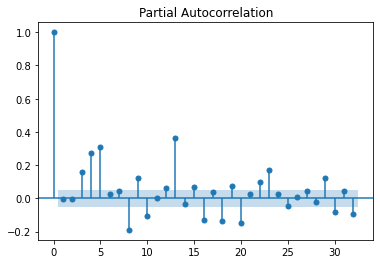

In [46]:
plotvolpercentchg = altdata_volpercentchg.filter(['Date', 'Percentchg'], axis=1) 
plotvolpercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_volpercentchg['Date']))) 
del plotvolpercentchg['Date']
sm.graphics.tsa.plot_pacf(plotvolpercentchg.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 3, 4, 5, 8, 9. 10, 12, 13, 15, 16, 18, 19, 20, 22, 23, 29, 30, 32. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

In [47]:
boolean_shock(2, bse_data, 'Close')

,Percentchg,Shock
Date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-12-23,0.950923,0
2020-12-24,1.139775,0
2020-12-28,0.809415,0


In [48]:
altdata_closepercentchg2 = boolean_shock(2, bse_data, 'Close')
altdata_closepercentchg2.reset_index(inplace=True)
altdata_closepercentchg2.rename(columns={list(altdata_closepercentchg2)[0]:'Date'}, inplace=True)

In [49]:
alt.Chart(altdata_closepercentchg2).mark_point().encode(
    x='Date',
    y='Percentchg'
)

alt.Chart(...)

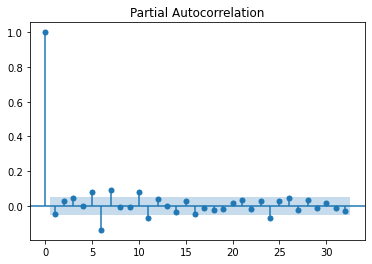

In [50]:
plotclosepercentchg2 = altdata_closepercentchg2.filter(['Date', 'Percentchg'], axis=1) 
plotclosepercentchg2.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg2['Date']))) 
del plotclosepercentchg2['Date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg2.values.squeeze())
plt.show()


In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 5, 6, 7, 10, 11, 24. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions



In [51]:
boolean_shock(10, bse_data, 'Close')

,Percentchg,Shock
Date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-12-23,0.950923,0
2020-12-24,1.139775,0
2020-12-28,0.809415,0


In [52]:
altdata_closepercentchg10 = boolean_shock(10, bse_data, 'Close')
altdata_closepercentchg10.reset_index(inplace=True)
altdata_closepercentchg10.rename(columns={list(altdata_closepercentchg10)[0]:'Date'}, inplace=True)

In [53]:
alt.Chart(altdata_closepercentchg10).mark_point().encode(
    x='Date',
    y='Percentchg'
)

alt.Chart(...)

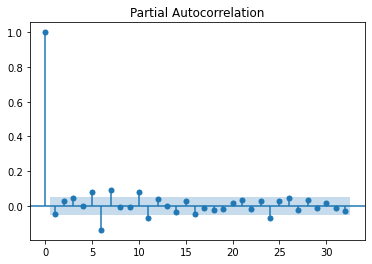

In [54]:
plotclosepercentchg10 = altdata_closepercentchg10.filter(['Date', 'Percentchg'], axis=1) 
plotclosepercentchg10.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg10['Date']))) 
del plotclosepercentchg10['Date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg10.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 5, 6, 7, 10, 11, 24. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

## Pricing shock without volume shock

In [55]:
def priceboolean_shock(percent, df):
    df['Date'] = pd.to_datetime(df['Date'])
    data = df.filter(['Date', 'High', 'Low','Close'], axis=1) 
    data.set_index('Date', inplace=True)
    data['Priceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['Shock'] = (data['Priceavg'].pct_change()) * 100
    data['Shock'] = data['Shock'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
    return data

In [56]:
priceboolean_shock(10, bse_data)

,Priceavg,Shock
Date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,0
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-12-23,46285.533854,0
2020-12-24,46855.319010,0
2020-12-28,47302.902344,0


In [57]:
altdata_pricepercentchg = priceboolean_shock(10, bse_data)
altdata_pricepercentchg.reset_index(inplace=True)
altdata_pricepercentchg.rename(columns={list(altdata_pricepercentchg)[0]:'Date'}, inplace=True)

In [58]:
alt.Chart(altdata_pricepercentchg).mark_point().encode(
    x='Date',
    y='Priceavg'
)

alt.Chart(...)

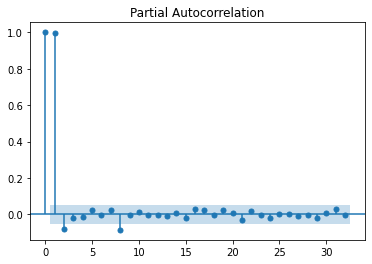

In [59]:
plotpricepercentchg = altdata_pricepercentchg.filter(['Date', 'Priceavg'], axis=1) #df.copy()
plotpricepercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_pricepercentchg['Date']))) 
del plotpricepercentchg['Date']
sm.graphics.tsa.plot_pacf(plotpricepercentchg.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 1, 2, 4, 6, 7, 8, 15, 16, 21, 22, 25, 26. And lag values 0, 1 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

# Creating the reverse dummy time series:
Price shocks : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether closing price at T vs T+1 has a difference > 2%. ( 0/1 dummy-coding is for direction of shock). This will be reverse of pct_change()





In [60]:
def reverseboolean_shock(percent, df, col):
    data = df.filter(['Date', col], axis=1) #df.copy()
    data.set_index('Date', inplace=True)
    data = data.reindex(index=data.index[::-1])
    data['Percentchg'] = (data[col].pct_change()) * 100
    data['Shock'] = data['Percentchg'].apply(lambda x: 1 if x > percent else 0)
    data.drop(col, axis = 1, inplace = True)
    data = data.reindex(index=data.index[::-1])
    return data.dropna()

In [61]:
reverseboolean_shock(2, bse_data, 'Close')

,Percentchg,Shock
Date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,1
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-12-22,-0.941966,0
2020-12-23,-1.126931,0
2020-12-24,-0.802916,0


In [62]:
altdata_closepercentchg = reverseboolean_shock(2, bse_data, 'Close')
altdata_closepercentchg.reset_index(inplace=True)
altdata_closepercentchg.rename(columns={list(altdata_closepercentchg)[0]:'Date'}, inplace=True)


In [63]:
alt.Chart(altdata_closepercentchg).mark_point().encode(
    x='Date',
    y='Percentchg'
)

alt.Chart(...)

Pricing black swan : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether closing price at T vs T+1 has a difference > 5%. ( 0/1 dummy-coding is for direction of shock). This will be reverse of pct_change()

In [64]:
reverseboolean_shock(5, bse_data, 'Close')

,Percentchg,Shock
Date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,0
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-12-22,-0.941966,0
2020-12-23,-1.126931,0
2020-12-24,-0.802916,0


In [65]:
altdata_closepercentchg5 = reverseboolean_shock(5, bse_data, 'Close')
altdata_closepercentchg5.reset_index(inplace=True)
altdata_closepercentchg5.rename(columns={list(altdata_closepercentchg5)[0]:'Date'}, inplace=True)


In [66]:
alt.Chart(altdata_closepercentchg5).mark_point().encode(
    x='Date',
    y='Percentchg'
)

alt.Chart(...)

Pricing shock without volume shock : Now we will be creating a time series for pricing shock without volume shock based on whether price at T vs T+1 has a difference > 2%. ( 0/1 dummy-coding is for direction of shock). This will be reverse of pct_change()

In [67]:
def pricereverseboolean_shock(percent, df):
    data = df.filter(['Date', 'High', 'Low','Close'], axis=1) 
    data.set_index('Date', inplace=True)
    data = data.reindex(index=data.index[::-1])
    data['Reversepriceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['Shock'] = (data['Reversepriceavg'].pct_change()) * 100
    data['Shock'] = data['Shock'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
    data = data.reindex(index=data.index[::-1])
    return data.dropna()

In [68]:
pricereverseboolean_shock(2, bse_data)


,Reversepriceavg,Shock
Date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,1
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-12-23,46285.533854,0
2020-12-24,46855.319010,0
2020-12-28,47302.902344,0


In [69]:
altdata_reversepricepercentchg = pricereverseboolean_shock(2, bse_data)
altdata_reversepricepercentchg.reset_index(inplace=True)
altdata_reversepricepercentchg.rename(columns={list(altdata_reversepricepercentchg)[0]:'Date'}, inplace=True)


In [70]:
alt.Chart(altdata_reversepricepercentchg).mark_point().encode(
    x='Date',
    y='Reversepriceavg'
)

alt.Chart(...)

# Textual Analysis of news from Times of India News Headlines

In [71]:
news=pd.read_csv("india-news-headlines.csv")

In [72]:
news.tail()

,publish_date,headline_category,headline_text
3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,removed,Govt extends deadline for use of FASTag till F...
3424066,20201231,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...


In [73]:
news['publish_date'] = pd.to_datetime(news['publish_date'], format = '%Y%m%d')

In [74]:
news.tail()

,publish_date,headline_category,headline_text
3424062,2020-12-31,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,2020-12-31,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,removed,Govt extends deadline for use of FASTag till F...
3424066,2020-12-31,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...


In [75]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 0 to 3424066
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 78.4+ MB


In [76]:
#finding unique values in headline_category
news['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'elections.assembly-elections.bihar',
       'astrology.horoscope.monthly', 'astrology.numerology-tarot'],
      dtype=object)

In [77]:
#checking all the values count (unique values total count)
news['headline_category'].value_counts()

india                                                    288541
unknown                                                  209582
city.mumbai                                              134428
city.delhi                                               127717
business.india-business                                  116761
                                                          ...  
himachal-pradesh                                              8
sports.tennis.top-stories.tennis-atp                          8
lifespan-news                                                 8
best-products.home-decor-and-garden.living-room-decor         8
business.faqs.gst-faqs                                        8
Name: headline_category, Length: 1013, dtype: int64

In [78]:
#total unique values count
news['headline_category'].value_counts().count()

1013

In [79]:
#checking all the values count (unique values total count)
news['headline_text'].value_counts()

Straight Answers                                                                     6723
Cartoons                                                                             1536
Straight answers                                                                     1500
Photogallery                                                                         1353
Your say                                                                             1012
                                                                                     ... 
PMC urged to put copy of development plan on record                                     1
19 societies now micro-contained                                                        1
21 days; 4444km; 17 cities: When these vintage beauties drove past Agra's streets       1
Sand extraction resumes at Amona despite HC direction                                   1
China's economic growth edges down in latest quarter                                    1
Name: head

In [80]:
#total unique values count
news['headline_text'].value_counts().count()

3168800

In [81]:
#finding if any null values are present
news.isnull().sum().sum()

0

In [82]:
#finding if any duplicate values are present
news.duplicated().sum()

24191

In [83]:
#rough checking by marking all duplicates as True. Default is first which marks duplicates as True except for the first occurrence.
news.duplicated(keep=False).sum()

46130

In [84]:
#sorting the dataset to delete the duplicates, to make duplicates come together one after another. 
#The sorted dataset index values are also changed
cols = list(news.columns)
news.sort_values(by=cols, inplace=True, ignore_index=True)

In [85]:
news[news.duplicated(keep=False)]

,publish_date,headline_category,headline_text
3,2001-01-02,unknown,America's unwanted heading for India?
4,2001-01-02,unknown,America's unwanted heading for India?
5,2001-01-02,unknown,America's unwanted heading for India?
6,2001-01-02,unknown,America's unwanted heading for India?
9,2001-01-02,unknown,BBC's reality TV will focus on AIIMS
...,...,...,...
3421893,2020-12-27,city.nagpur,Govt forcing helpless sr citizens to fight leg...
3422119,2020-12-28,city.bareilly,Rampur's Hunar Haat a platform for artisans fr...
3422120,2020-12-28,city.bareilly,Rampur's Hunar Haat a platform for artisans fr...
3422956,2020-12-29,city.pune,PMC to draft separate DP after 23 villages' me...


In [86]:
#dropping the duplicates only keeping the last value (ordinally last row from sorted) of each duplicates
news.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [87]:
#re-checking everything worked well with drop_duplicates() carried out earlier on the dataset
news.duplicated().sum()

0

In [88]:
from textblob import TextBlob




In [89]:
#getting a list of unique dates in publish_date column
lst = news['publish_date'].value_counts().index.tolist()

In [90]:
#concatenating all the headline_text column values of same date in publish_date column
new = []
for x in lst:
    df = news.loc[news['publish_date'] == x]
    headlinetext = ''
    publishdate = str(x)
    headlinetext = df['headline_text'].iloc[0]
    for i in range(1 , len(df)):
        headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
    new.append(headlinetext)

In [91]:
#creating a new dataset
newsdf = pd.DataFrame({'publish_date': lst, 'headline_text' : new})

In [92]:
newsdf

,publish_date,headline_text
0,2014-12-15,Golden Homes III. Golden Panorama. Hanging Gar...
1,2014-12-21,Eight companies add Rs 55;171 crore in m-cap; ...
2,2014-12-09,Audi-Vredestein driving experience. Benelli TN...
3,2014-11-29,6 CARE IPO merchant bankers fined Rs 1 crore. ...
4,2014-11-01,Chetan Bhagat: Cleanliness begins at home. Gau...
...,...,...
7257,2001-03-16,Tape and Tell
7258,2001-03-17,Crouching Tiger; Hidden Dragon
7259,2001-06-05,Darkness Triumphs
7260,2001-04-01,Indians attacked by 'monkey man'


In [93]:
#sorting the dataset based on dates
newsdf.sort_values(by='publish_date', inplace=True, ignore_index=True)
newsdf.head()

,publish_date,headline_text
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...
4,2001-01-06,Anti-immigration think-tank berates Clinton re...


In [94]:
newsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7262 entries, 0 to 7261
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   publish_date   7262 non-null   datetime64[ns]
 1   headline_text  7262 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 113.6+ KB


We can calculate the sentiment using TextBlob. Based on the polarity, we determine whether it is a positive text or negative or neutral. For TextBlog, if the polarity is more than 0, it is considered positive, if it is less than 0 then it is considered negative and if it ia=s equal to 0 is considered neutral. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

In [95]:
polarity = []
subjectivity = []
for idx, row in newsdf.iterrows():
    polarity.append(TextBlob(row['headline_text']).sentiment[0])
    subjectivity.append(TextBlob(row['headline_text']).sentiment[1])

In [96]:
newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity



In [97]:
newsdf.head()

,publish_date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [98]:
#finding if any null values are present
newsdf.isnull().sum().sum()

0

In [99]:
#renameing the publish_date to date so it will help us during joining this dataset with bse_data dataset
newsdf.rename(columns={'publish_date': 'Date'}, inplace = True)

In [100]:
newsdf

,Date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935
...,...,...,...,...
7257,2020-12-27,Horoscope Today; 27 December 2020: Check astro...,0.035346,0.396452
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.070784,0.414510
7259,2020-12-29,Horoscope Today; 29 December 2020: Check astro...,0.061175,0.424021
7260,2020-12-30,Horoscope Today; 30 December 2020: Check astro...,0.043919,0.441660


In [101]:
#selecting required columns
newsdf = newsdf.filter(['Date', 'polarity', 'subjectivity'], axis=1)


In [102]:
newsdf.shape

(7262, 3)

In [103]:
newsdf

,Date,polarity,subjectivity
0,2001-01-02,0.193519,0.293056
1,2001-01-03,0.088462,0.407692
2,2001-01-04,0.091426,0.481895
3,2001-01-05,0.257415,0.465542
4,2001-01-06,0.219481,0.464935
...,...,...,...
7257,2020-12-27,0.035346,0.396452
7258,2020-12-28,0.070784,0.414510
7259,2020-12-29,0.061175,0.424021
7260,2020-12-30,0.043919,0.441660


In [104]:
newsdf['Date'].duplicated().sum()

0

In [105]:
bse_data.shape

(1473, 7)

In [106]:
bse_data['Date'].duplicated().sum()

0

In [107]:
bse_data = pd.merge(bse_data, newsdf, how='left', on=['Date'])

In [108]:
bse_data.shape

(1473, 9)

In [109]:
bse_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,0.055586,0.455251
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,0.100081,0.433132
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,0.055802,0.386579
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,0.034707,0.386916
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,0.060173,0.408416


In [110]:
#finding if any null values are present
bse_data.isnull().sum().sum()

0

 
 # Preparing dataset for machine learning

In [111]:
#adding new row for 31 st December 2020 (price to be predicted of this day) to main dataset to get average values of all the columns for this day
#taking average because we don't know the values of all the columns for tomorrow so to predict we need average for independent variable.
#We will separate this row later from this main dataset so we can use this as prediction of unseen data for tomorrow. 
#And then tally it with actual data from unseenbse_data dataset which we have downloaded too for 31st December actual values
bse_data.loc[len(bse_data)] = ['2020-12-31', bse_data['Open'].mean(), bse_data['High'].mean(), bse_data['Low'].mean(),
                       bse_data['Close'].mean(), bse_data['Adj Close'].mean(), bse_data['Volume'].median(), 
                               newsdf['polarity'].mean(), newsdf['subjectivity'].mean() ]

In [112]:
#converting date from object dtype to datetime dtype
bse_data['Date'] = pd.to_datetime(bse_data['Date'], format="%Y-%m-%d")

In [113]:
bse_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
1469,2020-12-24,46743.488281,47053.398438,46539.019531,46973.539062,46973.539062,13700.0,0.047936,0.390942
1470,2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,47353.750000,9600.0,0.070784,0.414510
1471,2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,47613.078125,12800.0,0.061175,0.424021
1472,2020-12-30,47789.031250,47807.851562,47358.359375,47746.218750,47746.218750,15600.0,0.043919,0.441660
1473,2020-12-31,32756.475177,32910.536967,32523.740065,32710.765247,32710.765247,13400.0,0.069503,0.403839


In [114]:
bse_data["month"] = bse_data['Date'].dt.month
bse_data["day"] = bse_data['Date'].dt.day
bse_data["dayofweek"] = bse_data['Date'].dt.dayofweek
bse_data["week"] = bse_data['Date'].dt.week
bse_data['movingavg4weeks'] = round(bse_data['Close'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
bse_data['movingavg16weeks'] = round(bse_data['Close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
bse_data['movingavg28weeks'] = round(bse_data['Close'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
bse_data['movingavg40weeks'] = round(bse_data['Close'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
bse_data['movingavg52weeks'] = round(bse_data['Close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
bse_data['window10days'] = round(bse_data['Close'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
bse_data['window50days'] = round(bse_data['Close'].rolling(window = 50, min_periods = 1).mean().shift(),2)
bse_data['volumeShock'] = round(boolean_shock(10, bse_data, 'Volume').reset_index()['Shock'], 2)
bse_data['CloseShock2'] = round(reverseboolean_shock(2, bse_data, 'Close').reset_index()['Shock'], 2)
bse_data['CloseShock5'] = round(reverseboolean_shock(5, bse_data, 'Close').reset_index()['Shock'],2)
bse_data['CloseShock10'] = round(reverseboolean_shock(10, bse_data, 'Close').reset_index()['Shock'], 2)
bse_data['priceShock'] = round(priceboolean_shock(10, bse_data).reset_index()['Shock'], 2)
bse_data['reversebooleanShock2'] = round(reverseboolean_shock(2, bse_data, 'Close').reset_index()['Shock'], 2)
bse_data['reversebooleanShock5'] = round(reverseboolean_shock(5, bse_data, 'Close').reset_index()['Shock'], 2)
bse_data['pricereverseShock2'] = round(pricereverseboolean_shock(2, bse_data).reset_index()['Shock'], 2)
bse_data['polarity'] = round(bse_data['polarity'] , 2)
bse_data['subjectivity'] = round(bse_data['subjectivity'] , 2)
bse_data['price'] = round((bse_data['High'] + bse_data['Low'] + bse_data['Close']) / 3 , 2)
bse_data['Close'] = round(bse_data['Close'] , 2)

/root/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [115]:
bse_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'polarity', 'subjectivity', 'month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeShock', 'CloseShock2', 'CloseShock5', 'CloseShock10',
       'priceShock', 'reversebooleanShock2', 'reversebooleanShock5',
       'pricereverseShock2', 'price'],
      dtype='object')

In [116]:
bse_data

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity,month,...,window50days,volumeShock,CloseShock2,CloseShock5,CloseShock10,priceShock,reversebooleanShock2,reversebooleanShock5,pricereverseShock2,price
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.90,27887.900391,7400.0,0.06,0.46,1,...,NaN,1.0,0.0,0.0,0.0,0,0.0,0.0,0,27781.54
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.32,27842.320312,9200.0,0.10,0.43,1,...,27887.90,1.0,1.0,0.0,0.0,0,1.0,0.0,1,27897.89
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.46,26987.460938,14100.0,0.06,0.39,1,...,27865.11,0.0,0.0,0.0,0.0,0,0.0,0.0,0,27207.82
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.82,26908.820312,12200.0,0.03,0.39,1,...,27572.56,0.0,0.0,0.0,0.0,0,0.0,0.0,0,26912.18
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.71,27274.710938,8200.0,0.06,0.41,1,...,27406.63,1.0,0.0,0.0,0.0,0,0.0,0.0,0,27231.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,2020-12-24,46743.488281,47053.398438,46539.019531,46973.54,46973.539062,13700.0,0.05,0.39,12,...,43196.50,0.0,0.0,0.0,0.0,0,0.0,0.0,0,46855.32
1470,2020-12-28,47153.589844,47406.718750,47148.238281,47353.75,47353.750000,9600.0,0.07,0.41,12,...,43323.46,1.0,0.0,0.0,0.0,0,0.0,0.0,0,47302.90
1471,2020-12-29,47466.621094,47714.550781,47361.898438,47613.08,47613.078125,12800.0,0.06,0.42,12,...,43454.64,1.0,0.0,0.0,0.0,0,0.0,0.0,0,47563.18
1472,2020-12-30,47789.031250,47807.851562,47358.359375,47746.22,47746.218750,15600.0,0.04,0.44,12,...,43612.34,0.0,1.0,1.0,1.0,0,1.0,1.0,1,47637.48


In [117]:
#fillinf the null columns
bse_data.fillna(method = 'bfill', inplace = True)
#fillinf the null columns
bse_data.fillna(method = 'ffill', inplace = True)
#finding if any null values are present
bse_data.isnull().sum().sum()

0

In [118]:
#selecting specific columns
bse_data = bse_data.filter(['month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'closeshock2', 'closeshock5', 'closeshock10',
       'priceshock', 'reversebooleanshock2', 'reversebooleanshock5',
       'pricereverseshock2', 'polarity', 'subjectivity', 'price', 'Close'], axis=1)
bse_data

,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,window50days,polarity,subjectivity,price,Close
0,1,2,4,1,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,0.06,0.46,27781.54,27887.90
1,1,5,0,2,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,0.10,0.43,27897.89,27842.32
2,1,6,1,2,27865.11,27865.11,27865.11,27865.11,27865.11,27865.11,27865.11,0.06,0.39,27207.82,26987.46
3,1,7,2,2,27572.56,27572.56,27572.56,27572.56,27572.56,27572.56,27572.56,0.03,0.39,26912.18,26908.82
4,1,8,3,2,27406.63,27406.63,27406.63,27406.63,27406.63,27406.63,27406.63,0.06,0.41,27231.02,27274.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,12,24,3,52,45573.00,41515.01,39455.95,37037.42,37942.30,46309.78,43196.50,0.05,0.39,46855.32,46973.54
1470,12,28,0,53,45730.28,41619.33,39545.97,37079.94,37967.25,46411.15,43323.46,0.07,0.41,47302.90,47353.75
1471,12,29,1,53,45884.98,41724.99,39641.66,37128.82,37994.61,46536.62,43454.64,0.06,0.42,47563.18,47613.08
1472,12,30,2,53,46058.14,41831.58,39737.13,37188.71,38022.31,46672.59,43612.34,0.04,0.44,47637.48,47746.22


In [119]:
#separating the predicted date row from main dataset after getting all the calculated average values
main_bsedata = bse_data.iloc[:1473,:].reset_index()  
newtestunseen_bsedata = bse_data.iloc[1473:,:].reset_index()  

In [120]:
main_bsedata.shape

(1473, 16)

In [121]:
main_bsedata.tail()

,index,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,window50days,polarity,subjectivity,price,Close
1468,1468,12,23,2,52,45476.95,41427.80,39369.11,36997.25,37919.23,46275.72,43079.49,0.08,0.39,46285.53,46444.18
1469,1469,12,24,3,52,45573.00,41515.01,39455.95,37037.42,37942.30,46309.78,43196.50,0.05,0.39,46855.32,46973.54
1470,1470,12,28,0,53,45730.28,41619.33,39545.97,37079.94,37967.25,46411.15,43323.46,0.07,0.41,47302.90,47353.75
1471,1471,12,29,1,53,45884.98,41724.99,39641.66,37128.82,37994.61,46536.62,43454.64,0.06,0.42,47563.18,47613.08
1472,1472,12,30,2,53,46058.14,41831.58,39737.13,37188.71,38022.31,46672.59,43612.34,0.04,0.44,47637.48,47746.22


In [122]:
newtestunseen_bsedata.shape

(1, 16)

In [123]:
newtestunseen_bsedata

,index,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,window50days,polarity,subjectivity,price,Close
0,1473,12,31,3,53,46212.68,41941.02,39838.62,37248.96,38049.86,46820.89,43767.6,0.07,0.4,32715.01,32710.77


# Training the model and predicting the price of tomorrow 31th December 2020

In [125]:
X = main_bsedata.drop(['price','Close'], axis = 1)
y = main_bsedata[['price','Close']]

In [126]:
Xnewtestunseen = newtestunseen_bsedata.drop(['price','Close'], axis = 1)
ynewtestunseen_ans = newtestunseen_bsedata[['price','Close']]

In [127]:
X.shape, y.shape

((1473, 14), (1473, 2))

In [128]:
Xnewtestunseen.shape, ynewtestunseen_ans.shape

((1, 14), (1, 2))

In [129]:
split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [130]:
 X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1178, 14), (1178, 2), (295, 14), (295, 2))

In [132]:
rfg = RandomForestRegressor(random_state = 42, n_estimators = 500, criterion='mse', max_depth = 30, 
                            min_samples_leaf=2, min_samples_split=5, n_jobs=1)

In [133]:
chainedmodel = RegressorChain(rfg)
chainedmodel.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=30,
                                                    min_samples_leaf=2,
                                                    min_samples_split=5,
                                                    n_estimators=500, n_jobs=1,
                                                    random_state=42))

In [134]:
pred = chainedmodel.predict(X_test)
roundpred = []
for x in range(len(pred)):
    roundpred.append([round(pred[x][0], 2),round(pred[x][1], 2) ])

In [135]:
r2_score(y_test, roundpred) 

0.9872614585266573

In [136]:
#evaluating the performance of the model
#MAE
print('MAE')
print(mean_absolute_error(y_test, roundpred), end='\n')
#MSE
print('MSE')
print(mean_squared_error(y_test, roundpred), end='\n')
#RMSE
print('RMSE')
print(np.sqrt(mean_squared_error(y_test, roundpred)))

MAE
304.62803389830526
MSE
367926.84203627123
RMSE
606.5697338610552


In [137]:
pred_newtestunseen = chainedmodel.predict(Xnewtestunseen)
[(round(pred_newtestunseen[0][0], 2)),(round(pred_newtestunseen[0][1], 2))]

[47070.0, 47120.37]

In [138]:
ynewtestunseen_ans 

,price,Close
0,32715.01,32710.77


In [141]:
[hiddenbsedata_price[0] , round(hiddenbse_data['Close'],2)[0]] 
#actual price ((high+low+close)/3) calculated earlier and the closing price

[47750.14, 47751.33]

The model predicted for 31st December 2020 the price ((high+low+close)/3) i.e the average of high, low, close of BSE index to be 47070 and closing price to be 47120.33

And the actual price ((high+low+close)/3) i.e the average of high, low, close of BSE index on day 31st December 2020 was 47750.14, and closing price was 47751.33

So as seen above our model has done a very good prediction